# Baseline Models
We wish for our weather prediction model to be better than something simple.

We will create two simple models here to benchmark the model we make later.

The first will be just extending the last point in the series out across our prediction period.

The second will be a basic RNN with no optimisations.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Normalizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Dense, Dropout, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#### Import the data, format the date and split


In [2]:
#import data
df = pd.read_csv('../Data/weather_data.csv')

#get temp and time
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y')
df = df.set_index('datetime')

#split final week for plotting. Validation data
train_data = df['temp'].iloc[:-457]
val_data = df['temp'].iloc[-457:-7]
test_data = df['temp'].iloc[-7:]

train_data.head()

datetime
2014-10-16    13.8
2014-10-17    15.1
2014-10-18    17.0
2014-10-19    16.1
2014-10-20    13.1
Name: temp, dtype: float64

#### Model 1: extend last value in sequence
Yup, super simple. Lets just assume the temperature will never change

Our later model will take in a sequence of values and then try to predict what the nect value will be. So we will set things up in a similar way here to keep things fair. 

Lets say the sequence length is 10 days and the 11th must be predicted.

so for this model we will assume that the temperature on the 11th day is the same as the 10th. We will roll this forward across our validation set to get a baseline Mean Absolute Error.

In [3]:
length = 10

val_generator = TimeseriesGenerator(data=val_data, targets=val_data, length=length, batch_size=1)

Our input sequence

In [4]:
val_generator[0][0]

array([[ 4.3,  6.5,  6.4, 10.8,  9.3,  6.8,  5.9,  5.3,  7.3,  6.4]])

The next value in the series (what we need to predict)

In [5]:
val_generator[0][1]

array([9.9])

So we're actually going to predict that the next value is **6.4.**

This gives us an error of **-3.5**

In [6]:
val_generator[0][0][:,-1] - val_generator[0][1]

array([-3.5])

So lets do this across the whole validation set

In [7]:
num_preds = len(val_data) - length
preds = []

for i in range(num_preds):
    preds.append(val_generator[i][0][:,-1][0])
    
preds = pd.Series(preds, index = val_data.index[length:])

In [8]:
preds

datetime
2020-02-22    6.4
2020-02-23    9.9
2020-02-24    9.5
2020-02-25    8.4
2020-02-26    5.2
             ... 
2021-05-02    6.9
2021-05-03    8.2
2021-05-04    8.5
2021-05-05    8.5
2021-05-06    5.7
Length: 440, dtype: float64

All we've really done is shifted the series back by one step. I just wanted to show off the TimeSeriesGenerator class.
Lets Calculate the mean absolute error on the validation set.

In [9]:
(preds - val_data).abs().mean()

1.614545454545455

**1.61C** is the average error with this rule of thumb

#### Model 2
We'll be using Tensorflow 2 to make our optimised model later. Lets build a simple one now to see what our later tuning will have to beat.
First we must scale our data so that it can be passed into the model

In [10]:
#scale data
scaler = MinMaxScaler()
scaler.fit(train_data.values.reshape(-1,1))
train_scaled = scaler.transform(train_data.values.reshape(-1,1))
validation_scaled = scaler.transform(val_data.values.reshape(-1,1))

In [11]:
#data generator 
generator = TimeseriesGenerator(data=train_scaled, targets=train_scaled, length=length, batch_size=1)
val_generator = TimeseriesGenerator(data=validation_scaled, targets=validation_scaled, length=length, batch_size=1)

Lets use a callback to stop the model from overfitting. Let's use another to save the best model.

In [12]:
#callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_cp = ModelCheckpoint(filepath='models/baseline_rnn.h5', save_weights_only=False, monitor='val_mae', save_best_only=True)

#### Basic Sequential LSTM model

In [13]:
model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(length, 1)))
model.add(Dense(1))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Compile and fit

In [38]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(generator, validation_data=val_generator, epochs=200, callbacks=[early_stop, model_cp])

Epoch 1/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0074 - mae: 0.0671 - val_loss: 0.0073 - val_mae: 0.0675
Epoch 2/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0049 - mae: 0.0556 - val_loss: 0.0043 - val_mae: 0.0505
Epoch 3/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0042 - mae: 0.0512 - val_loss: 0.0044 - val_mae: 0.0515
Epoch 4/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0042 - mae: 0.0511 - val_loss: 0.0040 - val_mae: 0.0486
Epoch 5/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0041 - mae: 0.0505 - val_loss: 0.0041 - val_mae: 0.0492
Epoch 6/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0041 - mae: 0.0506 - val_loss: 0.0043 - val_mae: 0.0506
Epoch 7/200
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0041 - mae: 0.0504 - val_loss: 0.0042 - val_mae: 0.0505
Epoch 8/200
1933/1933 [==============================] 

Load the best model

In [14]:
baseline_model = tf.keras.models.load_model('models/baseline_rnn.h5')

Get predictions and transform the back to orginal units

In [15]:
preds = baseline_model.predict(val_generator)

In [16]:
preds = pd.Series(scaler.inverse_transform(preds).round(1)[:,0],
                  index = val_data[length:].index)

In [17]:
preds

datetime
2020-02-22    6.4
2020-02-23    9.8
2020-02-24    8.7
2020-02-25    8.2
2020-02-26    5.5
             ... 
2021-05-02    7.1
2021-05-03    8.3
2021-05-04    8.3
2021-05-05    8.3
2021-05-06    5.9
Length: 440, dtype: float32

Those preds look slightly different to what we had before. Lets see what the MAE is.

In [18]:
(preds - val_data[length:]).abs().mean()

1.5456818160482424

**1.54C** is our MAE. Granted there is a little bias here due to us guiding the training off the back of the validation set.
So it might be fair to assume that this model did not do much more than projecting the last value forward like in model 1


#### Plot Predictions

In [19]:
def plotPreds(predictions, test_series=None, run_up=None,\
              ylabel='units'):
    """
    plot the predictions of the model. plot them against another series
    (test series). plot with with a run up leading to the pred period
    (validation set).
    """
    #set up figure
    plt.figure(figsize=(10,6))
    plt.ylabel(ylabel)
    plt.xlabel('datetime')

    #plot lines
    if test_series is not None:
        plt.plot(pd.concat([run_up, test_series[:1]]))
        plt.plot(test_series)

    else:
        plt.plot(run_up)

    #plot points
    plt.scatter(predictions.index, predictions, edgecolors='k',\
                label='predictions', c='#2ca02c', s=64)

    if test_series is not None:
        plt.scatter(test_series.index, test_series, marker='X',\
                    edgecolors='k', label='test_data', c='#ff7f0e', s=200)

    plt.legend()

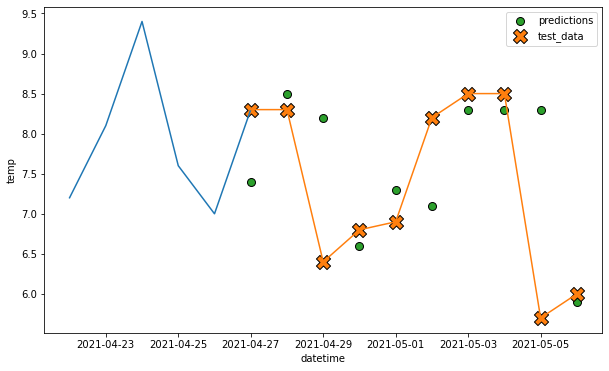

In [20]:
plotPreds(preds[-10:], val_data[-10:], val_data[-15:-10], 'temp')

The predictions are largely just shifting the previous value forward (there is at least some deviation). This is most evident when there is a more significant move in temperature. 